In [186]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder


In [187]:
df = pd.read_csv('co2_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7385 entries, 0 to 7384
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Make                              7385 non-null   object 
 1   Model                             7385 non-null   object 
 2   Vehicle Class                     7385 non-null   object 
 3   Engine Size(L)                    7385 non-null   float64
 4   Cylinders                         7385 non-null   int64  
 5   Transmission                      7385 non-null   object 
 6   Fuel Type                         7385 non-null   object 
 7   Fuel Consumption City (L/100 km)  7385 non-null   float64
 8   Fuel Consumption Hwy (L/100 km)   7385 non-null   float64
 9   Fuel Consumption Comb (L/100 km)  7385 non-null   float64
 10  Fuel Consumption Comb (mpg)       7385 non-null   int64  
 11  CO2 Emissions(g/km)               7385 non-null   int64  
dtypes: flo

In [188]:
df.describe()

,Engine Size(L),Cylinders,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
count,7385.000000,7385.000000,7385.000000,7385.000000,7385.000000,7385.000000,7385.000000
mean,3.160068,5.615030,12.556534,9.041706,10.975071,27.481652,250.584699
std,1.354170,1.828307,3.500274,2.224456,2.892506,7.231879,58.512679
min,0.900000,3.000000,4.200000,4.000000,4.100000,11.000000,96.000000
25%,2.000000,4.000000,10.100000,7.500000,8.900000,22.000000,208.000000
50%,3.000000,6.000000,12.100000,8.700000,10.600000,27.000000,246.000000
75%,3.700000,6.000000,14.600000,10.200000,12.600000,32.000000,288.000000
max,8.400000,16.000000,30.600000,20.600000,26.100000,69.000000,522.000000


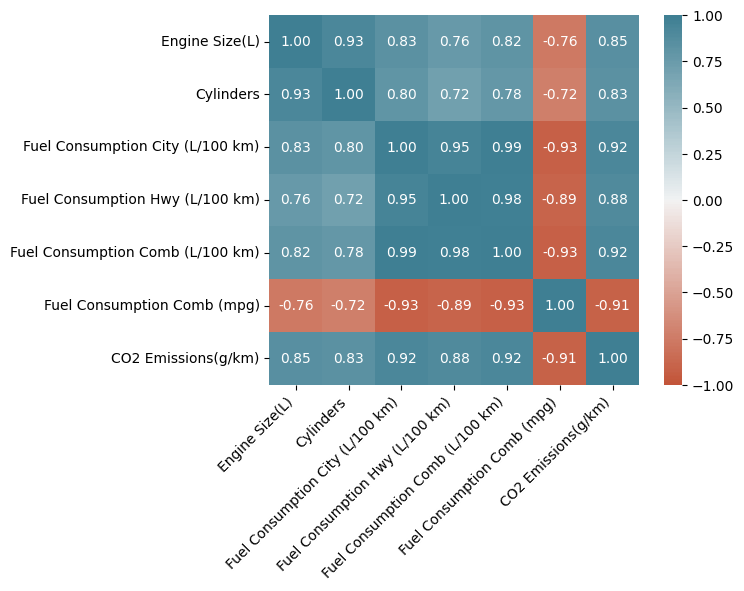

In [189]:
numeric_features = df.select_dtypes(exclude=['object'])
corr = numeric_features.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    annot=True,
    fmt='.2f',
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [190]:
corr_dict = {col : df['CO2 Emissions(g/km)'].corr(df[col]) for col in numeric_features.columns}
for k,v in sorted(corr_dict.items(), key=lambda x: x[1], reverse=True):
    print(f'{k}: {v}',"\n")

CO2 Emissions(g/km): 0.9999999999999999 

Fuel Consumption City (L/100 km): 0.9195924749024846 

Fuel Consumption Comb (L/100 km): 0.9180515723870845 

Fuel Consumption Hwy (L/100 km): 0.8835359454649436 

Engine Size(L): 0.8511446437900011 

Cylinders: 0.8326436002237771 

Fuel Consumption Comb (mpg): -0.9074262866541869 



The negative correlation between Fuel Consumption Comb (mpg) and CO2 Emissions(g/km) shows strong they move in opposite directions. These could be because of using different Units for measurement.

In [191]:
conversion_factor = 235.214

df["Fuel Consumption Comb (L/100 km)"] = conversion_factor/df["Fuel Consumption Comb (mpg)"]
print(df["CO2 Emissions(g/km)"].corr(df["Fuel Consumption Comb (L/100 km)"]))

0.9176255518074707


After unit conversion we see that the problem got fixed. Now we can use this new feature.

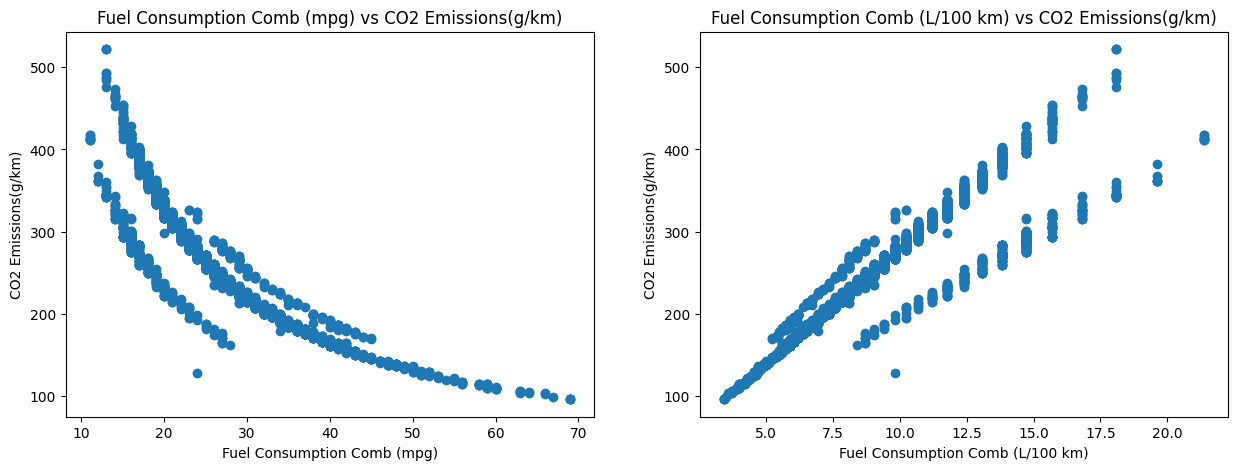

In [192]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].scatter(df['Fuel Consumption Comb (mpg)'], df['CO2 Emissions(g/km)'])
axes[0].set_title('Fuel Consumption Comb (mpg) vs CO2 Emissions(g/km)')
axes[0].set_xlabel('Fuel Consumption Comb (mpg)')
axes[0].set_ylabel('CO2 Emissions(g/km)')
axes[1].scatter(df['Fuel Consumption Comb (L/100 km)'], df['CO2 Emissions(g/km)'])
axes[1].set_title('Fuel Consumption Comb (L/100 km) vs CO2 Emissions(g/km)')
axes[1].set_xlabel('Fuel Consumption Comb (L/100 km)')
axes[1].set_ylabel('CO2 Emissions(g/km)')
plt.show()

In [193]:
categorigal_features = df.select_dtypes(include=['object'])
categorigal_features.describe()

,Make,Model,Vehicle Class,Transmission,Fuel Type
count,7385,7385,7385,7385,7385
unique,42,2053,16,27,5
top,FORD,F-150 FFV 4X4,SUV - SMALL,AS6,X
freq,628,32,1217,1324,3637


C:\Users\Hosein\AppData\Local\Temp\ipykernel_8424\1037511238.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


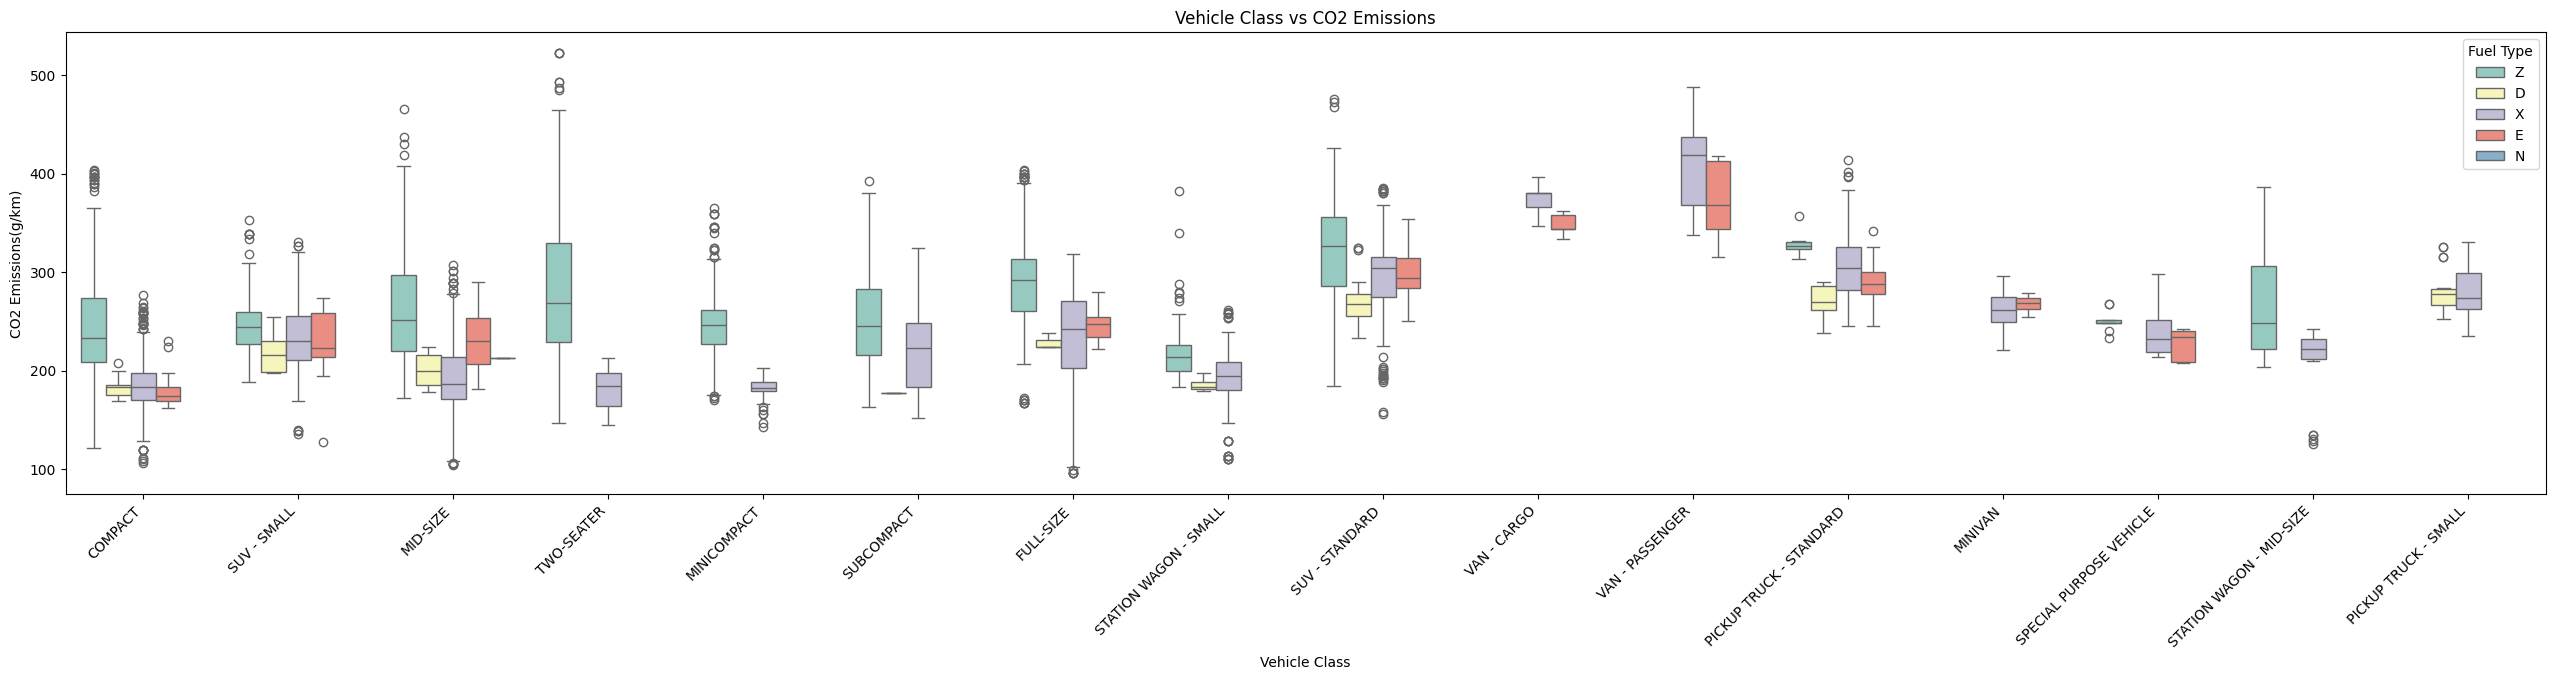

In [194]:
plt.figure(figsize=(32, 6))
ax = sns.boxplot(data=df, x='Vehicle Class', y='CO2 Emissions(g/km)',hue='Fuel Type', palette='Set3')
ax = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Vehicle Class vs CO2 Emissions')
plt.show()

C:\Users\Hosein\AppData\Local\Temp\ipykernel_8424\3740648979.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)


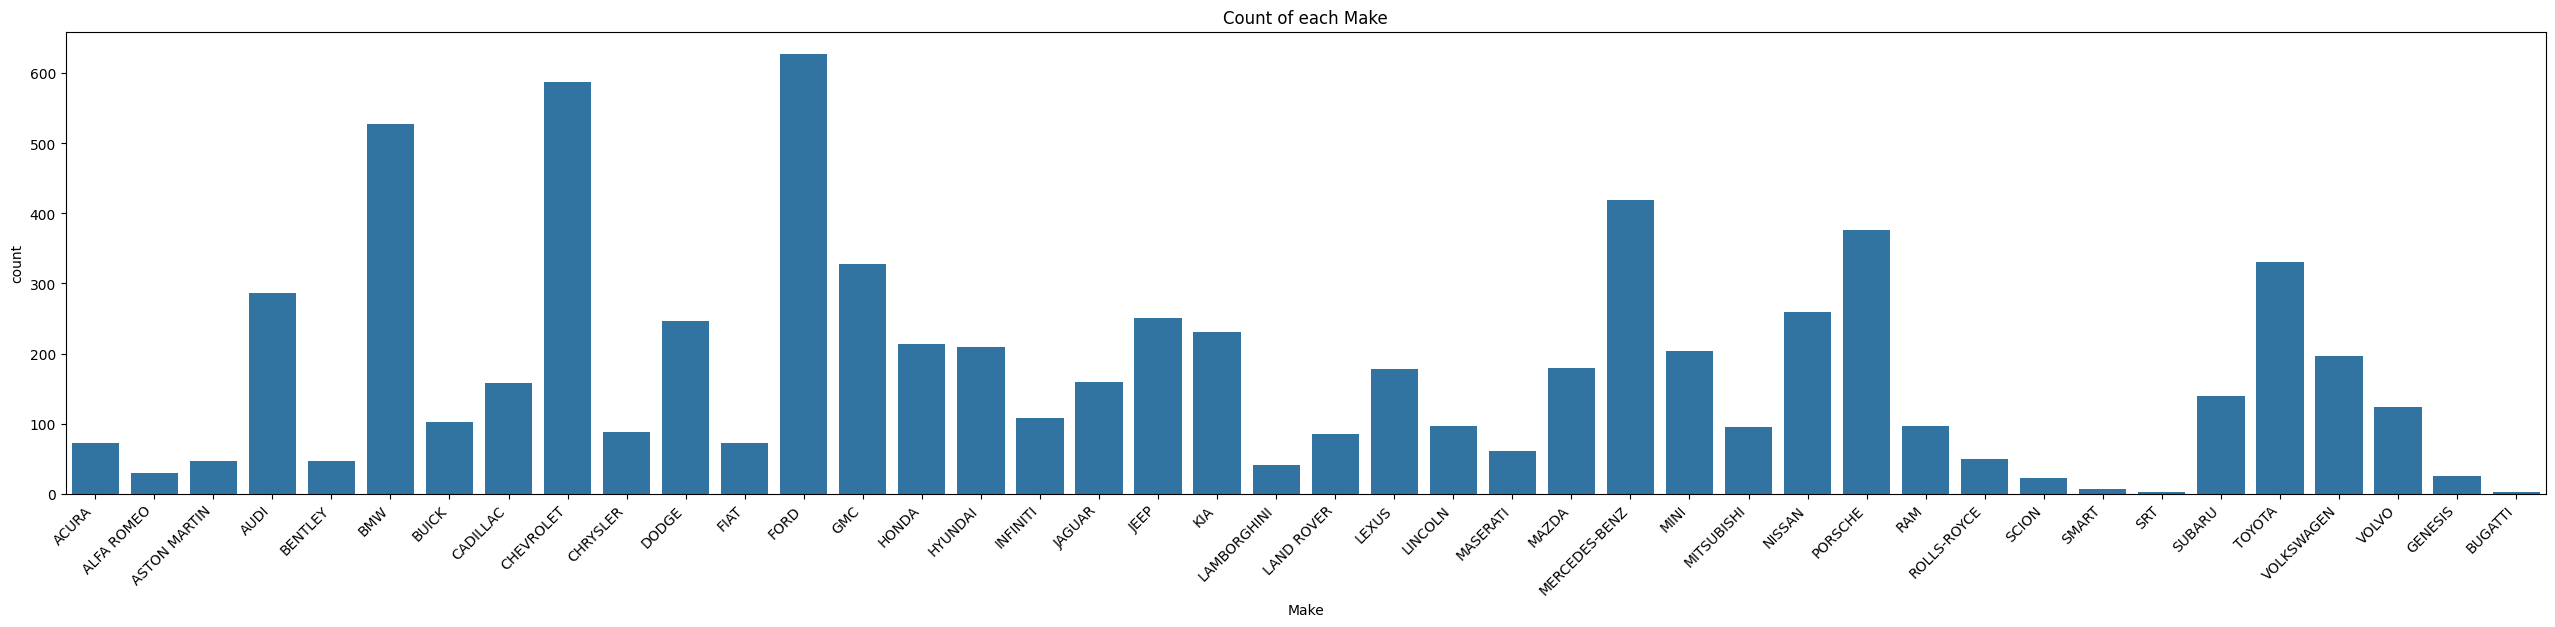

In [195]:
plt.figure(figsize=(32, 6))
ax = sns.countplot(data=df, x='Make')
plt.title('Count of each Make')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
plt.show()

Most of the Vehicle classes have a normal distribution. but some of them are skewed. It 's possible that we have some outliers because of the points passing the min and max boundary of the boxes.

In [196]:
from sklearn.preprocessing import OneHotEncoder

print(df['Vehicle Class'].value_counts())
encoder =  OneHotEncoder(handle_unknown='ignore',sparse_output=False)
encoded_features = encoder.fit_transform(df[["Vehicle Class"]])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out())
df= pd.concat([df.drop(["Vehicle Class"], axis=1), encoded_df], axis=1)

Vehicle Class
SUV - SMALL                 1217
MID-SIZE                    1133
COMPACT                     1022
SUV - STANDARD               735
FULL-SIZE                    639
SUBCOMPACT                   606
PICKUP TRUCK - STANDARD      538
TWO-SEATER                   460
MINICOMPACT                  326
STATION WAGON - SMALL        252
PICKUP TRUCK - SMALL         159
MINIVAN                       80
SPECIAL PURPOSE VEHICLE       77
VAN - PASSENGER               66
STATION WAGON - MID-SIZE      53
VAN - CARGO                   22
Name: count, dtype: int64


In [197]:
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(df[["Make"]])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out())
df = pd.concat([df.drop(["Make"], axis=1), encoded_df], axis=1)


C:\Users\Hosein\AppData\Local\Temp\ipykernel_8424\665937816.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)


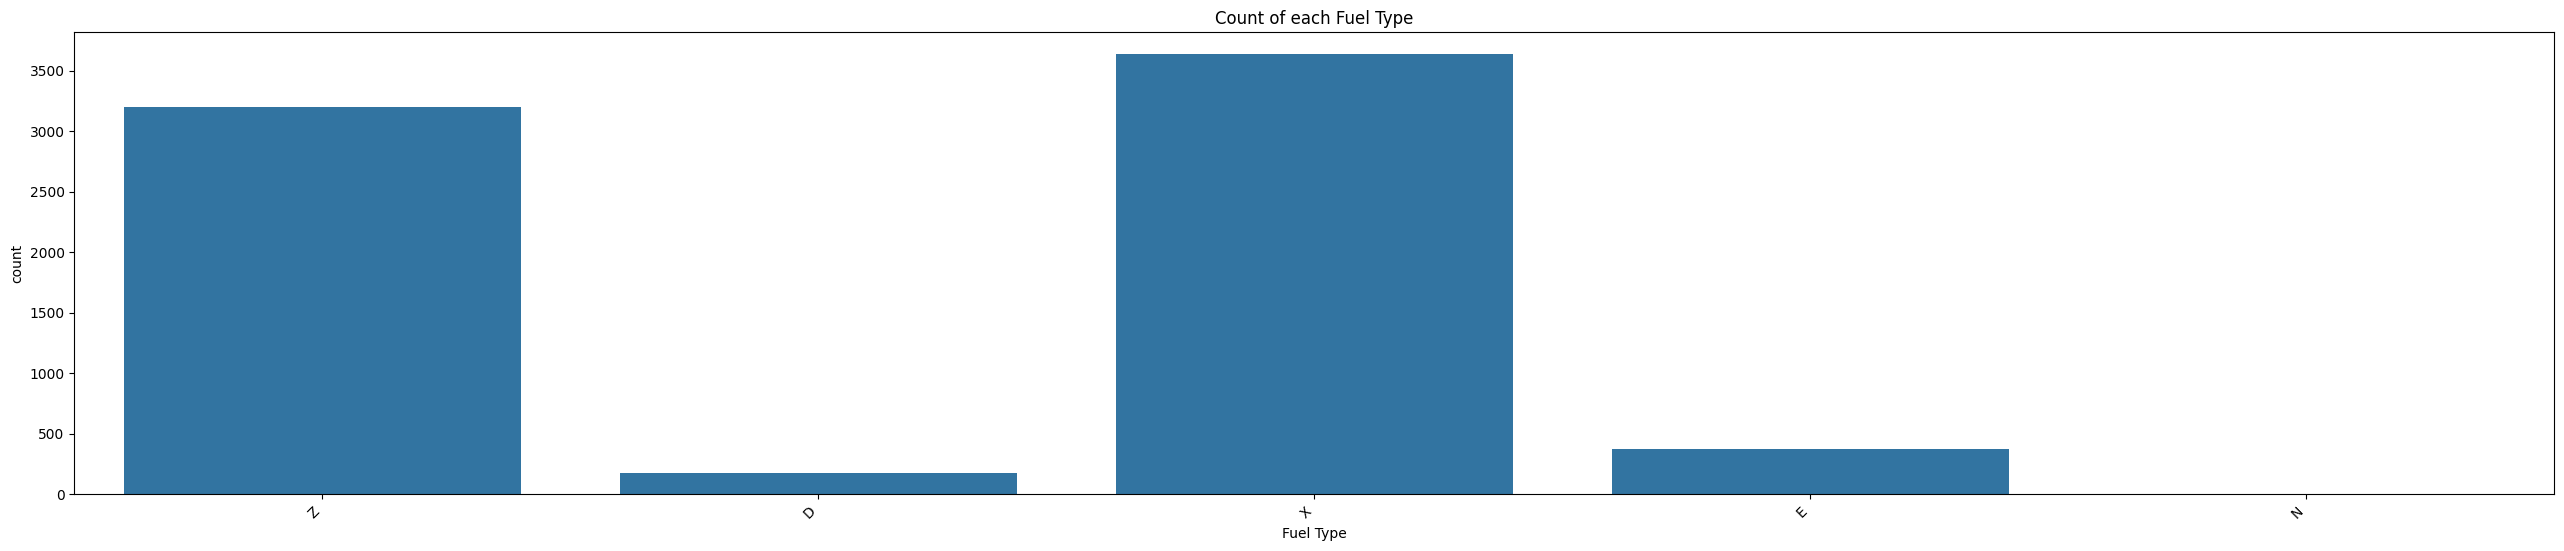

In [198]:
plt.figure(figsize=(32, 6))
ax = sns.countplot(data=df, x='Fuel Type')
plt.title('Count of each Fuel Type')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
plt.show()

In [199]:
fuel_type_n = df[df["Fuel Type"] == "N"]
print(fuel_type_n.shape)
df.isna().sum()

(1, 68)


Model              0
Engine Size(L)     0
Cylinders          0
Transmission       0
Fuel Type          0
                  ..
Make_SRT           0
Make_SUBARU        0
Make_TOYOTA        0
Make_VOLKSWAGEN    0
Make_VOLVO         0
Length: 68, dtype: int64

Fuel Type N has only one row. This should be dropped because it does not convey any information.

In [200]:

drop_index = df[df["Fuel Type"] == "N"].index
df.drop(drop_index[0], inplace=True)
df.shape

(7384, 68)

In [201]:
labelencoder = OrdinalEncoder(categories=[['X','Z','E','D']])
encoded_type = labelencoder.fit_transform(df[["Fuel Type"]])
df_type= pd.DataFrame(encoded_type, columns=["Fuel Labels"])
shape = df_type.shape

df = pd.concat([df.drop(["Fuel Type"], axis=1), df_type], axis=1)
df.dropna(inplace=True)

<Axes: xlabel='Fuel Consumption Comb (L/100 km)', ylabel='CO2 Emissions(g/km)'>

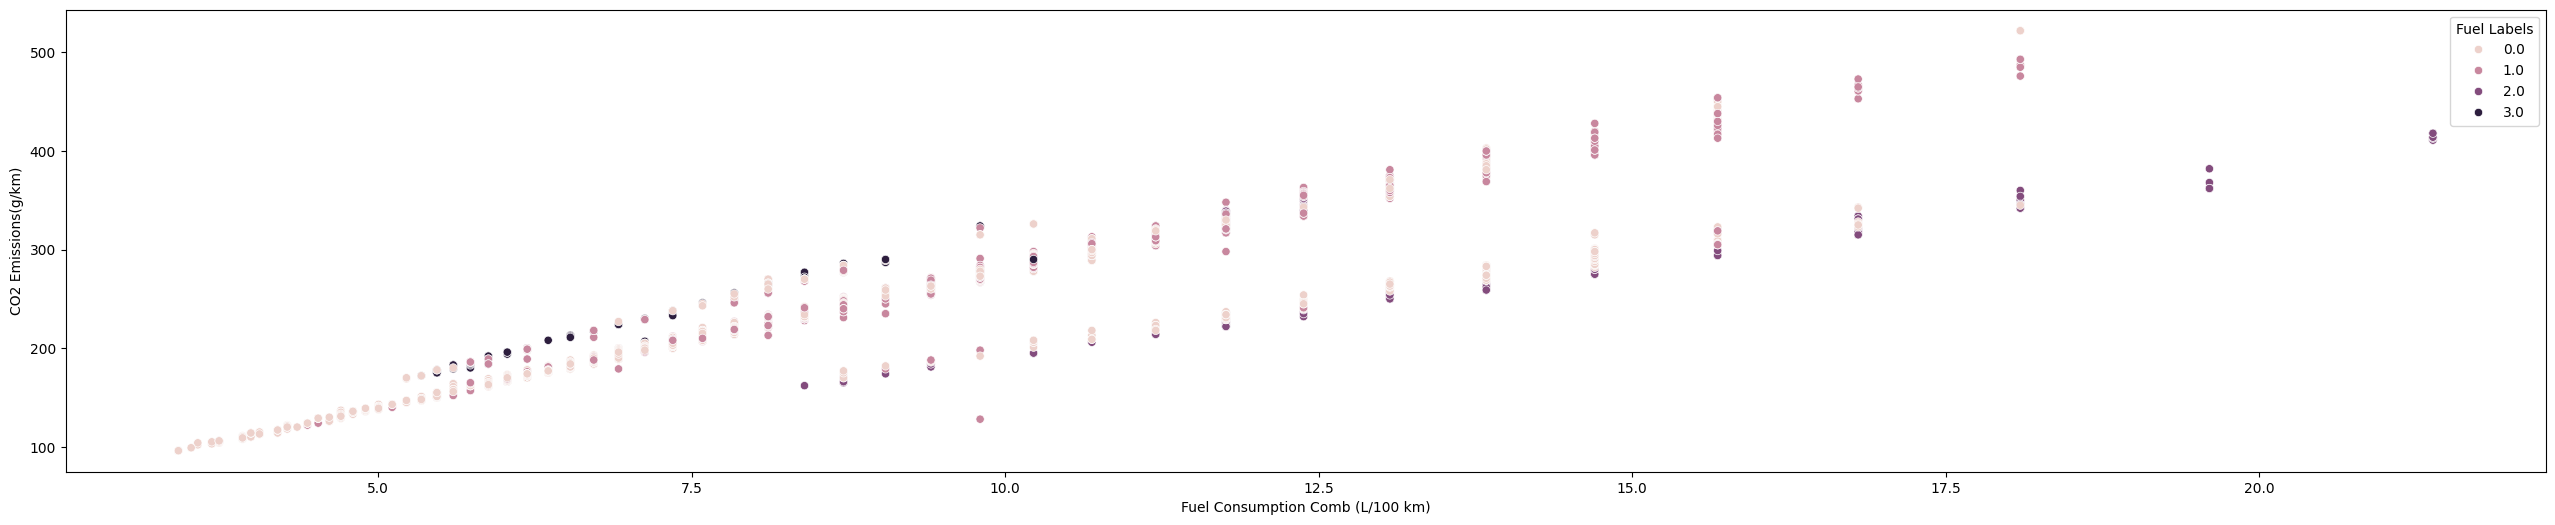

In [202]:
plt.figure(figsize=(32,6))
sns.scatterplot(data=df, x='Fuel Consumption Comb (L/100 km)', y='CO2 Emissions(g/km)', hue='Fuel Labels')

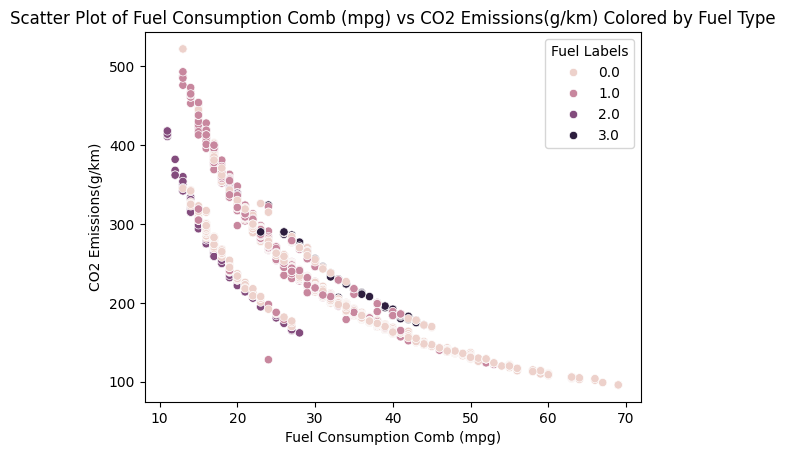

In [203]:
sns.scatterplot(data=df, x='Fuel Consumption Comb (mpg)', y='CO2 Emissions(g/km)', hue='Fuel Labels')
plt.title('Scatter Plot of Fuel Consumption Comb (mpg) vs CO2 Emissions(g/km) Colored by Fuel Type')
plt.show()

This new plot indicates 3 main categories. Fuel Type 3, 4 and 5 has relatively lowe emission compared to Fule Types 1 and 2. Also There should be a relation between Fuel Type and CO2 emission. 

In [204]:
df.drop(['Transmission','Model'], axis=1, inplace=True)

In [205]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('CO2 Emissions(g/km)', axis=1), df['CO2 Emissions(g/km)'], test_size=0.2, random_state=62)

In [206]:
model = LinearRegression()
model.fit(x_train, y_train)
y_train_pred = model.predict(x_train)
y_pred = model.predict(x_test)

mse = metrics.mean_squared_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)
mae = metrics.mean_absolute_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')
print(f'Mean Absolute Error: {mae}')

print(f'Coefficient: {model.coef_}')
print(f'Intercept: {model.intercept_}')

Mean Squared Error: 235.79529847969357
R-squared: 0.9280390240069553
Mean Absolute Error: 10.779967350273418
Coefficient: [ 11.59348719   3.74783778   1.9493927    2.66587814  -3.3898391
  -3.82897946 -11.34602407 -12.72644663 -12.29947465 -14.3479023
  -6.6507041   18.66438458  -0.61078713  -4.76166146 -13.12517914
  -8.30136026 -10.01692264  -5.54774525   2.56184085  -5.40503783
  25.78696073  58.1260593  -17.21246946  -1.38672239   9.58144981
   0.3039285   28.39491336  -2.69277094  94.65617383  -6.49623161
  -1.3517073  -13.96986527 -23.87892989 -13.14554485  -5.31243271
  -9.85257068   7.95896675 -19.80392504 -11.89943092  -3.77761945
  -8.07770958  -2.95478893  -6.96536406  -4.08927337  48.36560952
   0.91835219 -12.2997046    5.97911874  28.24491325 -15.08767716
  -1.51679643  -4.60072333  -8.62092992  -9.86088563  -4.23917565
  -6.10877682  25.17042082  -8.30174342  -6.34359968   5.10539443
  -6.65816494 -10.44987954  -3.58510747  -4.13872017  -1.86208937]
Intercept: 294.648656

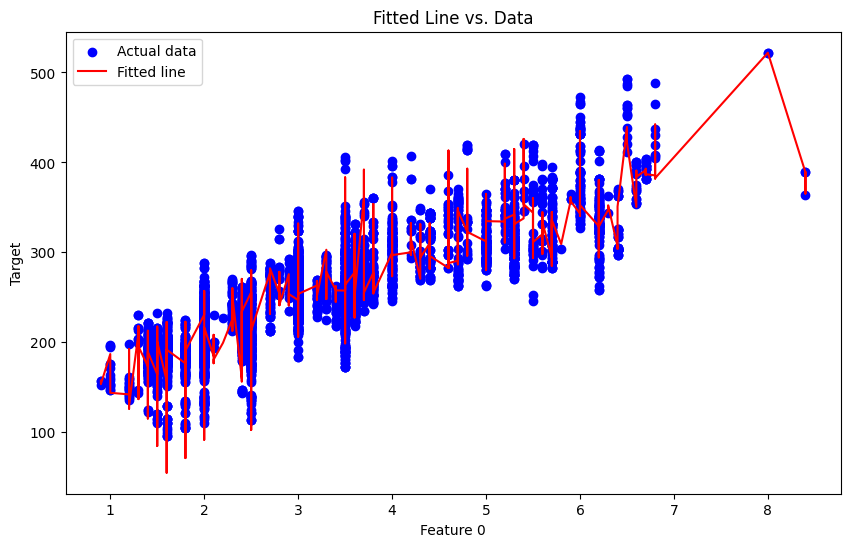

In [207]:

yfeature_index = 0
y_train_pred = model.predict(x_train)
plt.figure(figsize=(10, 6))
plt.scatter(x_train.iloc[:, yfeature_index].values, y_train, color='blue', label='Actual data')
sorted_zip = sorted(zip(x_train.iloc[:, yfeature_index].values, y_train_pred), key=lambda x: x[0])
x, y_pred = zip(*sorted_zip)
plt.plot(x, y_pred, color='red', label='Fitted line')

plt.xlabel(f'Feature {yfeature_index}')
plt.ylabel('Target')
plt.title('Fitted Line vs. Data')
plt.legend()
plt.show()

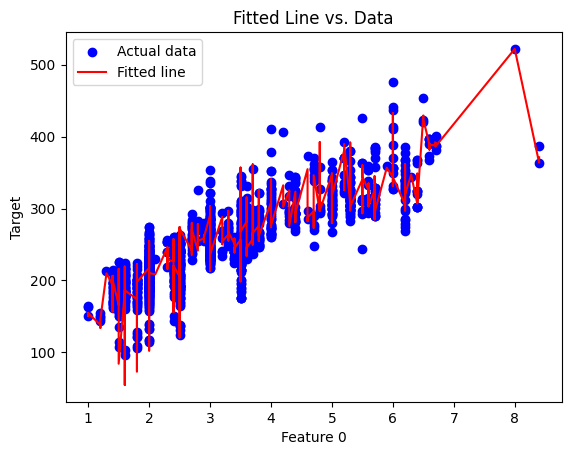

In [208]:
yfeature_index = 0
y_pred = model.predict(x_test)
plt.scatter(x_test.iloc[:, yfeature_index], y_test, color='blue', label='Actual data')
sorted_zip = sorted(zip(x_test.iloc[:, yfeature_index].values, y_pred), key=lambda x: x[0])
x, y_pred = zip(*sorted_zip)
plt.plot(x, y_pred, color='red', label='Fitted line')

plt.xlabel(f'Feature {yfeature_index}')
plt.ylabel('Target')
plt.title('Fitted Line vs. Data')
plt.legend()
plt.show()

In [209]:
model = Lasso(alpha=0.01)
model.fit(x_train, y_train)
y_train_pred = model.predict(x_train)
y_pred = model.predict(x_test)

mse = metrics.mean_squared_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)
mae = metrics.mean_absolute_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 235.13366136848992
R-squared: 0.9282409451333832
Mean Absolute Error: 10.718729504867472


c:\Users\Hosein\anaconda3\envs\fetch\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.114e+03, tolerance: 2.044e+03
  model = cd_fast.enet_coordinate_descent(


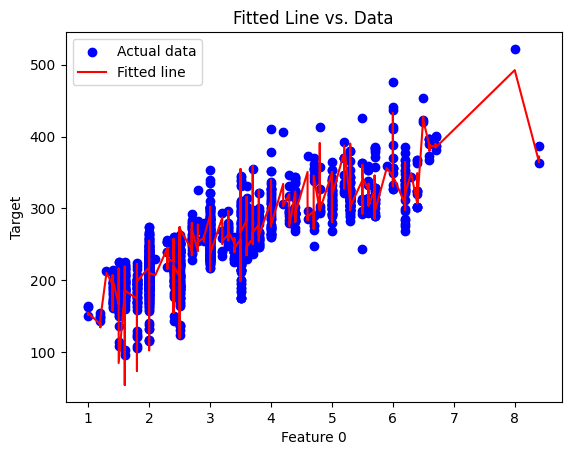

In [210]:
yfeature_index = 0
y_pred = model.predict(x_test)
plt.scatter(x_test.iloc[:, yfeature_index], y_test, color='blue', label='Actual data')
sorted_zip = sorted(zip(x_test.iloc[:, yfeature_index].values, y_pred), key=lambda x: x[0])
x, y_pred2 = zip(*sorted_zip)
plt.plot(x, y_pred2, color='red', label='Fitted line')

plt.xlabel(f'Feature {yfeature_index}')
plt.ylabel('Target')
plt.title('Fitted Line vs. Data')
plt.legend()
plt.show()


In [211]:
model = RandomForestRegressor(n_estimators=100, random_state=62)
model.fit(x_train, y_train)
y_train_pred = model.predict(x_train)
y_pred = model.predict(x_test)

mse = metrics.mean_squared_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)
mae = metrics.mean_absolute_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 31.76413441906845
R-squared: 0.9903060912193409
Mean Absolute Error: 2.247518317036379


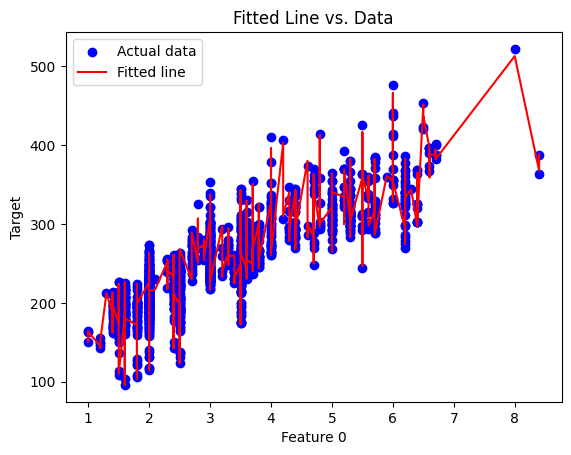

In [212]:
yfeature_index = 0
y_pred = model.predict(x_test)
plt.scatter(x_test.iloc[:, yfeature_index], y_test, color='blue', label='Actual data')
sorted_zip = sorted(zip(x_test.iloc[:, yfeature_index].values, y_pred), key=lambda x: x[0])
x, y_pred2 = zip(*sorted_zip)
plt.plot(x, y_pred2, color='red', label='Fitted line')

plt.xlabel(f'Feature {yfeature_index}')
plt.ylabel('Target')
plt.title('Fitted Line vs. Data')
plt.legend()
plt.show()

Between these models RandomForestRegression outperforms the other methods such as Linear, Ridge, Lasso regression. 0.99 Variance of data is captured by RandomForest and we see that other metrics also are better. The problem with Linear regression even after regularization could be because of some problems in our feature Engineering process. Maybe adding new features or dropping some of them that have small correlation helps us to boost performance. One of the possible solution is also using polynomial regressors.